# Приоритизация гипотез и проведение A/B теста

Отдел маркетинга крупного интернет-магазина подготовили список гипотез для увеличения выручки, а также провёл A/B тестирование новой фичи/функции на сайте.

**Цель исследования** 
1. Определить, какие гипотезы с большей веротяностью способствуют увеличению выручки
2. Проанализировать результаты уже проведенного A/B-теста и сделать выводы об эффективности новой функции

**Ход исследования**

1. Приоритизировать гипотезы, с применением фрэймфворков ICE и RICE
2. Определить, как изменилась приоритизация гипотез при применении RICE вместо ICE
3. Построить графики кумулятивной выручки,кумулятивного среднего чека по группам и относительного изменения кумулятивного среднего чека группы B к группе A
4. Пострить графики кумулятивной конверсии по группам, относительного изменения кумулятивной конверсии группы B к группе A
5. Построить точечный график стоимостей заказов и количества заказов по пользователям
6. Посчитать 95-й и 99-й перцентили стоимости заказов и  количества заказов на пользователя. Выбрать границу для определения аномальных пользователей и аномальных заказов
7. Посчитать статистическую значимость различий в конверсии и среднем чеке заказа между группами по «сырым» данным
8. Посчитать статистическую значимость различий в конверсии и среднем чеке заказа между группами по «очищенным» данным. 
9. Сделать выводы об эффективности новой функции

## Изучение данных и подготовка к анализу

### Загрузка данных

Согласно полученно документации нам представлены следующие данные:
1. Таблица **Hypothesis** с гипотезами
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
2. Таблица **orders** c перечнем заказов
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ
3. Таблица **visits** с количеством посетителей в каждую дату
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

Импортируем необходимые библиотеки и откроем файлы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import scipy.stats as stats

In [2]:
try:
    hypo, orders, visits = (
    pd.read_csv('hypothesis.csv'),
    pd.read_csv('orders.csv'),
    pd.read_csv('visitors.csv')
)
except:
    hypo, orders, visits = (
    pd.read_csv('/Users/ASUS/Учебные проекты/7_Принятие решений в бизнесе/hypothesis.csv'),
    pd.read_csv('/Users/ASUS/Учебные проекты/7_Принятие решений в бизнесе/orders.csv'),
    pd.read_csv('/Users/ASUS/Учебные проекты/7_Принятие решений в бизнесе/visitors.csv')
)

### Первичный анализ

Посмотрим общую информацию по каждому файлу

In [3]:
def data_info(data):
    data.columns = data.columns.str.lower()
    display(data.head())
    print('*' *40)
    data.info()
    print('*' * 40)
    print(f' Количество явных дубликатов - {data.duplicated().sum()}')
    print('*' * 40)
    print(f' Количество пропусков - {data.isna().sum()}');

In [4]:
pd.set_option('max_colwidth', None)

In [5]:
[data_info(_) for _ in (hypo, orders, visits)];

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
****************************************
 Количество явных дубликатов - 0
****************************************
 Количество пропусков - hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
****************************************
 Количество явных дубликатов - 0
****************************************
 Количество пропусков - transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
****************************************
 Количество явных дубликатов - 0
****************************************
 Количество пропусков - date        0
group       0
visitors    0
dtype: int64


Таблица **hypo** состоит всего из 10 строк. В ней какие-либо проблемы отстуствуют.

Таблицы **orders** и **visits** пообъёмнее. В них требуется поменять тип данных в столбцах с датами и поправить название столбцов `transactionid` и `visitorid`

Пропуски и дубликаты не обнаружены.

### Предобработка данных

Скорректируем названия столбцов `transactionid` и `visitorid` и добавим пробелы, чтобы улучшить восприятие текста.

In [6]:
orders.columns = ('transaction_id', 'visitor_id', 'date', 'revenue', 'group')

Изменим тип данных в столбцах с датами во всех таблицах

In [7]:
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

### Поиск аномалий

Рассмотрим датасеты подробнее, вдруг в них есть какие-либо аномальные и выбивающиеся из общей массы значения.

In [8]:
display(orders.agg({'date' : (min, max),'revenue' : (min, max)}),
        visits.agg({'date' : (min, max)}))

,date,revenue
min,2019-08-01,50
max,2019-08-31,1294500


,date
min,2019-08-01
max,2019-08-31


Диапазон дат в обеих таблицах совпадает - с 01 августа 2019 г. по 31 августа 2019 г. Здесь все в порядке

Но видим, что диапазон значений выручки варьируется от 50 долларов до 1,29 млн долларов. Рассмотрим распределение значений выручки подробнее.

In [9]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

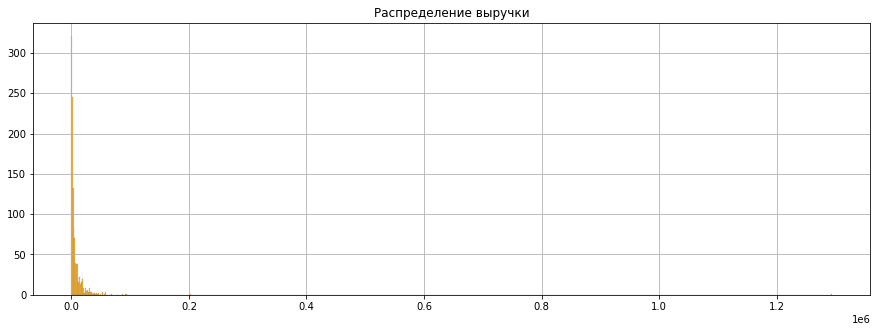

In [10]:
plt.figure(figsize=(15,5))
sns.histplot(orders['revenue'], color='orange')
plt.title('Распределение выручки')
plt.xlabel('')
plt.ylabel('')
plt.grid();

Видим, что в данных имеются выбросы, т.к. медианное значение выручки 2,9 тыс. долларов и 3/4 значений находятся в пределах 8 тыс. долларов, и гистограмма с очень "жирным" хвостом - покупкой в 1 млн. долларов. 

Отфильтруем выручку и посмотрим много ли значений больше 50 тыс. долларов.

In [11]:
orders[orders['revenue'] > 50000]

,transaction_id,visitor_id,date,revenue,group
60,1421016313,4256040402,2019-08-16,56650,B
131,3163614039,2254586615,2019-08-22,53904,A
287,587872075,2254456485,2019-08-24,53904,A
425,590470918,1920142716,2019-08-19,1294500,B
613,4071177889,3931967268,2019-08-07,53904,B
662,1811671147,4266935830,2019-08-29,78990,A
682,1216533772,4266935830,2019-08-29,78990,B
743,3603576309,4133034833,2019-08-09,67990,A
744,3668308183,888512513,2019-08-27,86620,B
858,192721366,1316129916,2019-08-27,93940,A


Всего 21 покупка, две из которых значительно выбиваются из ряда. Это 0,2 млн. и 1,2 млн.

Запомним это и вернемся позднее.

Рассмотрим, как распределены пользователи и заказы между группами тестирования.

In [12]:
orders.groupby('group').agg({'visitor_id' : 'nunique'})

,visitor_id
group,
A,503
B,586


In [13]:
orders.groupby('group').agg({'transaction_id' : 'nunique'})

,transaction_id
group,
A,557
B,640


Видим, что распределение неравномерное, хотя ожидалось, что в обоих группах будет одинаковое число участников или заказов.

Также проверим, попадаются ли одни и те же пользователи в обеих группах

In [14]:
orders.pivot_table(index='visitor_id', values='group', aggfunc='nunique').reset_index().query('group > 1')['visitor_id'].count()

58

Всего таких 58 человек. Исключать не будем, т.к. нам все равно не получится удалить их из таблицы **visits**

### Выводы

В полученных данных:
1. отсутствуют пропуски
2. отсутствуют явные дубликаты
3. нарушения стиля устранены
4. типы данных изменены
5. обнаружены аномальные значения выручки (рассмотрим их в следующих разделах)
6. разделение групп для А/В теста неравномерное. Передадим наши замечания отделу маркетинга

Можем работать с данными

## Приоритизация гипотез

Для определения наиболее приоритетной гипотезы воспользуемся методами 
- **ICE** (Impact Confidence Ease/ Efforts) 
- **RICE** (Reach Impact Confidence Efforts)

Данные возьмем из таблицы с гипотезами **hypo**, в которой перечислены гипотезы и проставлены ранги по десятибальной системе следующим факторам:
- Reach (охват пользователей)
- Impact (влияние)
- Confidence (уверенность в оценке факторов) 
- Efforts (Трудозатраты или сложность реализации гипотезы)

### Метод ICE

Сначала применим метод **ICE**

In [15]:
hypo['ice'] = hypo['confidence'] * hypo['impact'] / hypo['efforts']
hypo.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Наиболее перспективной для разработки выглядит гипотеза №8 о запуске акции в день рождения. Также в Топ3 входят гипотез №0 и №7.

### Метод RICE

Теперь применим метод RICE и посмотрим на различия в результатах.

In [16]:
hypo['rice'] = hypo['reach'] * hypo['confidence'] * hypo['impact'] / hypo['efforts']
hypo.sort_values(by='rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


### Выводы

Видим, что позиции гипотез по уровню их приоритета перераспределились. Благодаря высоким значениям охвата наибольший коэффициент RICE получила гипотеза №7, а гипотеза №2 оказалась второй. 

Лидер по методике ICE опустился на пятое место - коэффициент охвата у него минимальный. В нижней части таблицы изменений практически нет.

Для метода RICE нужен дополнительный фактор, но благодаря ему можно более детально подойти к определению приоритета гипотезы.

## A/B тестирование

Проанализируем результаты проведенного А/В теста. Для этого изучим таблицы **orders** и **visits**.
В них указаны данные о месячных показателях выручки и посетителей, разбитые на группы А и В.

- Группа А - это контрольная группа. С ней будут сравниваться результаты
- Группа В - тестовая группа, на которой проверяли нововведения

### Изучение выручки по группам

Сначала рассмотрим выручку по каждой из групп тестирования. 

Предварительно соберем данные с кумулятивной выручкой, количеством посетителей, покупателей и заказов в одной таблице.

In [17]:
dates_groups = orders[['date', 'group']].drop_duplicates()

orders_agg = (
dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
        'date': max,
        'group': max, 
        'transaction_id' : 'nunique' ,
        'visitor_id': 'nunique',
        'revenue' : sum}), axis=1).sort_values(by=['date','group'])
)

visitors_agg = (
dates_groups.apply(
    lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({
        'date': max,
        'group' : max,
        'visitors' : sum}), axis=1).sort_values(by=['date','group'])
)

cumulative_data = orders_agg.merge(visitors_agg, on=['date','group'], how='left')
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [18]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Получили таблицу куммулятивных метрик. По ней уже будем строить графики. Предварительно проверим, совпадают ли минимальная и максимальная даты из исходного датафрейма с минимальной и максимальной датой в новом датафрейме cumulative_data.

In [19]:
cumulative_data.agg({'date' : (min, max)})

,date
min,2019-08-01
max,2019-08-31


#### Построение графика кумулятивной выручки по группам

Для каждой группы создадим переменную со срезом по группе тестирования. Оставим столбцы с датой, кумулятивным количеством заказов и кумулятивной выручкой.

In [20]:
cumulative_revenue_a = cumulative_data.query('group == "A"')[['date', 'orders', 'revenue']]
cumulative_revenue_b = cumulative_data.query('group == "B"')[['date', 'orders', 'revenue']]

display(
cumulative_revenue_a.head(),
cumulative_revenue_b.head()
)

,date,orders,revenue
0,2019-08-01,24,148579
2,2019-08-02,44,242401
4,2019-08-03,68,354874
6,2019-08-04,84,425699
8,2019-08-05,109,549917


,date,orders,revenue
1,2019-08-01,21,101217
3,2019-08-02,45,266748
5,2019-08-03,61,380996
7,2019-08-04,78,489567
9,2019-08-05,101,581995


С их помощью построим графики кумулятивной выручки по группам

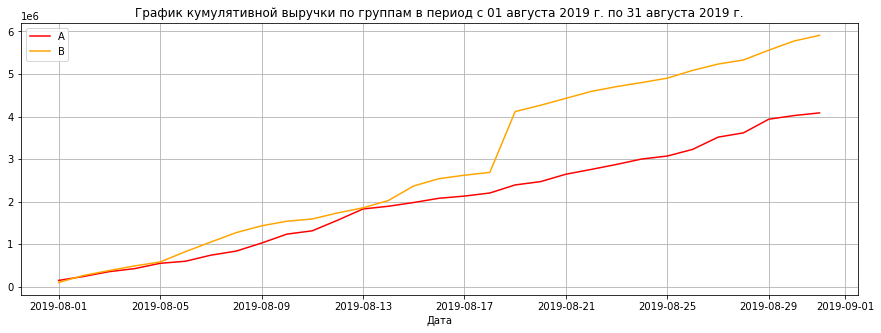

In [21]:
plt.figure(figsize=(15,5))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A', color='red')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B', color='orange')
plt.legend()
plt.title('График кумулятивной выручки по группам в период с 01 августа 2019 г. по 31 августа 2019 г.')
plt.xlabel('Дата')
plt.grid()

Видим, что до 19 августа кумулятивные выручки обеих групп практически одинаковы, у группы В выручка стабильно больше.

Но затем 19 августа происходит скачок, который сильно "поднимает" линию группы В на графике. При этом далее оба графика идут практически параллельно друг другу. 

Как раз 19 августа в группе В была зафиксирована аномальная покупка на 1,2 млн. Эффект от этой покупки мы и наблюдаем на графике.

#### Построение графика кумулятивного среднего чека по группам

Построим графики кумулятивного среднего чека по группам

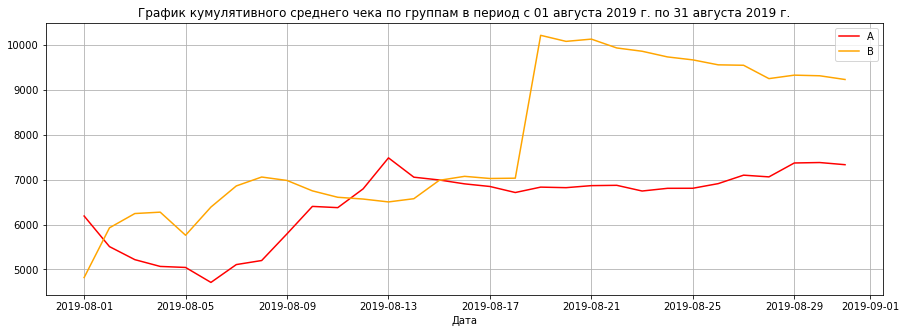

In [22]:
plt.figure(figsize=(15,5))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label='A', color='red')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/ cumulative_revenue_b['orders'], label='B', color='orange')
plt.legend()
plt.title('График кумулятивного среднего чека по группам в период с 01 августа 2019 г. по 31 августа 2019 г.')
plt.xlabel('Дата')
plt.grid()

Видим, что 
1. средний чек группы А до 06 мая уменьшается, а затем показывает рост и стабилизируется в районе 7000. 
2. средний чек в группе В растет скачкообразно и  так же, как и на предыдущем графике резко увеличивается 19 августа. Но после 19го августа идет на снижение. 

Предполагаю, что если убрать аномальные значения, то средний чек по группе В окажется меньше, чем в группе А.

#### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Он позволит наглядно показать разницу между средним чеком обеих групп.

In [23]:
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, on='date', suffixes=('_a', '_b'))

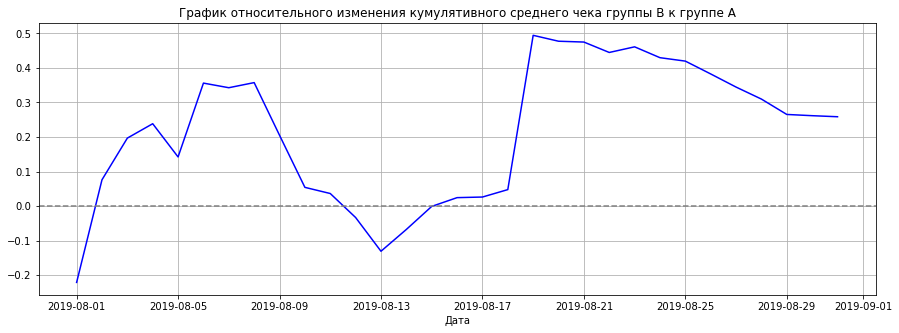

In [24]:
plt.figure(figsize=(15,5))
plt.plot(merged_cumulative_revenue['date'],
         (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b']) / 
         (merged_cumulative_revenue['revenue_a'] / merged_cumulative_revenue['orders_a']) - 1, color='blue')
plt.grid()
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.axhline(y=0, color='grey', linestyle='--');

Видим, что график "лихорадит": сначала подъем, затем спад 08 августа, и снова подъем. С 18 августа разница снова уменьшается, но ,кажется , стабилизируется на отметке в 25%. При этом группа В все равно стабильно лучше группы А.

#### "Упаковка" кода в функцию

Из написанного выше кода сделаем функцию, чтобы в дальнейшем иметь возможность сформировать нужные таблицы и построить графики по новым данным.

Функция для получения таблиц кумулятивной выручки и кумулятивного среднего чека

In [25]:
def cumulative_dt(orders,visits):
    orders_agg = (
    dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
        'date': max,
        'group': max, 
        'transaction_id' : 'nunique' ,
        'visitor_id': 'nunique',
        'revenue' : sum}), axis=1).sort_values(by=['date','group']))

    visitors_agg = (
    dates_groups.apply(
    lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({
        'date': max,
        'group' : max,
        'visitors' : sum}), axis=1).sort_values(by=['date','group']))

    cumulative_data = orders_agg.merge(visitors_agg, on=['date','group'], how='left')
    cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

    cumulative_revenue_a = cumulative_data.query('group == "A"')[['date', 'orders', 'revenue']]
    cumulative_revenue_b = cumulative_data.query('group == "B"')[['date', 'orders', 'revenue']]
    
    merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, on='date', suffixes=('_a', '_b'))
        
    return cumulative_data, cumulative_revenue_a, cumulative_revenue_b,merged_cumulative_revenue

Функция для построения графиков кумулятивной выручки, кумулятивного среднего чека и относительного изменения среднего чека

In [26]:
def revenue_plot(rev_a, rev_b, merged_cumulative_revenue):
    plt.figure(figsize=(15,5))
    plt.plot(rev_a['date'], rev_a['revenue'], label='A', color='red')
    plt.plot(rev_b['date'], rev_b['revenue'], label='B', color='orange')
    plt.legend()
    plt.title('График кумулятивной выручки по группам в период с 01 августа 2019 г. по 31 августа 2019 г.')
    plt.xlabel('Дата')
    plt.grid()

    plt.figure(figsize=(15,5))
    plt.plot(rev_a['date'], rev_a['revenue'] / rev_a['orders'], label='A', color='red')
    plt.plot(rev_b['date'], rev_b['revenue']/ rev_b['orders'], label='B', color='orange')
    plt.legend()
    plt.title('График кумулятивного среднего чека по группам в период с 01 августа 2019 г. по 31 августа 2019 г.')
    plt.xlabel('Дата')
    plt.grid()

    plt.figure(figsize=(15,5))
    plt.plot(merged_cumulative_revenue['date'],
             (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b']) / 
             (merged_cumulative_revenue['revenue_a'] / merged_cumulative_revenue['orders_a']) - 1, color='blue')
    plt.grid()
    plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
    plt.xlabel('Дата')
    plt.axhline(y=0, color='grey', linestyle='--');   

### Изучение конверсии по группам

Посмотрим динамику кумулятивной конверсии для каждой группы

#### Построение графика кумулятивной конверсии по группам

Добавим столбец с конверсией к таблице `cumulative_data` и создадим переменные со срезом по каждой группе. Затем построим графики

In [27]:
cumulative_data['conversion'] = cumulative_data['buyers'] / cumulative_data['visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.027816
1,2019-08-01,B,21,20,101217,713,0.028050
2,2019-08-02,A,44,38,242401,1338,0.028401
3,2019-08-02,B,45,43,266748,1294,0.033230
4,2019-08-03,A,68,62,354874,1845,0.033604


In [28]:
cumulative_conversion_a = cumulative_data.query('group == "A"')[['date','conversion']]
cumulative_conversion_b = cumulative_data.query('group == "B"')[['date','conversion']]

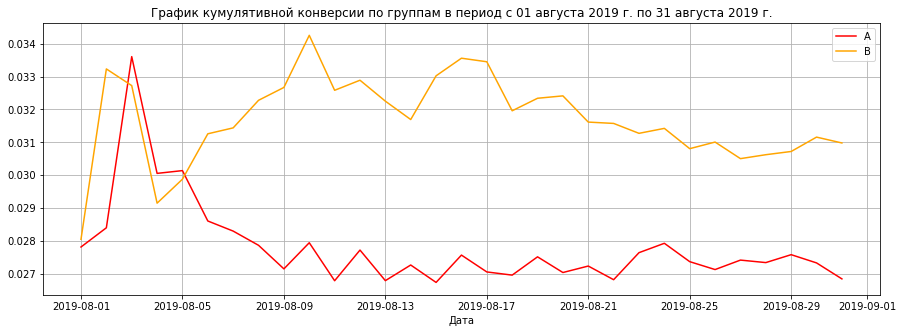

In [29]:
plt.figure(figsize=(15,5))
plt.plot(cumulative_conversion_a['date'], cumulative_conversion_a['conversion'], label='A', color='red')
plt.plot(cumulative_conversion_b['date'], cumulative_conversion_b['conversion'], label='B', color='orange')
plt.legend()
plt.title('График кумулятивной конверсии по группам в период с 01 августа 2019 г. по 31 августа 2019 г.')
plt.xlabel('Дата')
plt.grid();

1. Наблюдаем резкие колебания графиков обеих групп в первые дни
2. После 8 августа конверсия группы B повысилась и затем начала стабилизировалаться в районе 3,1%, а конверсия группы А ,наоборот, понизилась, колебалась между 2,7% и 2,8%, а затем снова пошла на снижение.
3. Конверсия группы Б стабильно выше конверсии в группе А.

#### Построение графика относительного изменения конверсии группы B к группе A

Построим график относительного изменения конверсии группы В к группе А

In [30]:
merged_cumulative_conversion = cumulative_conversion_a.merge(cumulative_conversion_b, on='date', suffixes=('_a', '_b'))

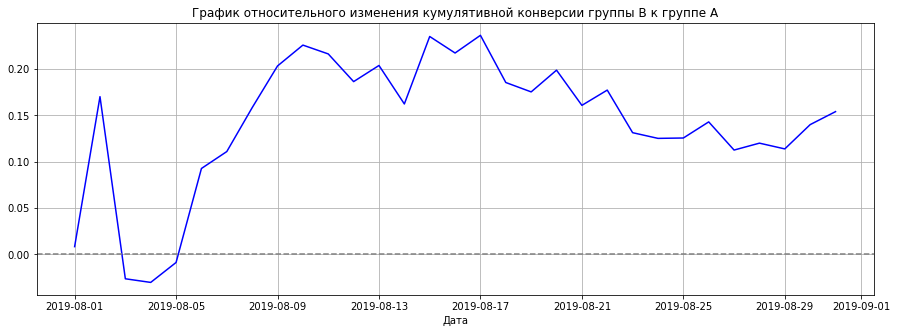

In [31]:
plt.figure(figsize=(15,5))
plt.plot(merged_cumulative_conversion['date'],
         (merged_cumulative_conversion['conversion_b']) / 
         (merged_cumulative_conversion['conversion_a']) - 1, color='blue')
plt.grid()
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.axhline(y=0, color='grey', linestyle='--');

Видим, что кумулятивная конверсия группы В стабильно выше группы А. Только со 2го по 5е августа виден провал. Далее разница только положительная и в последние 10 дней месяца составляет в среднем 15%. Прирост конверсии группы B стально выше 10%.

### Изучение количества и стоимости заказов

В разделе 1 мы уже нашли некоторые аномальные значения стоимости заказов. Гистограмма неудобна для более детального изучения выбросов, поэтому нам необходимо построить точечные графики

#### Построение точечного графика количества заказов по пользователям

Создадим переменную с разбивкой количества уникальных заказов на каждого пользователя и по ней построим точечный график.

In [32]:
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})
orders_by_users.columns = ['userId', 'orders']
orders_by_users

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


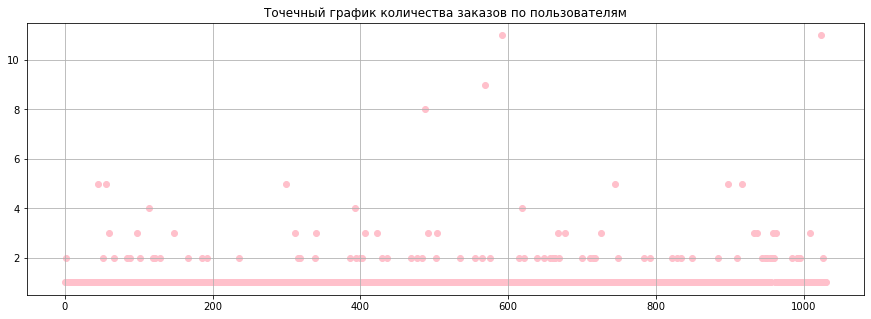

In [33]:
x_values = pd.Series(range(0,len(orders_by_users['orders'])))

plt.figure(figsize=(15,5))
plt.scatter(x_values, orders_by_users['orders'], color='pink')
plt.grid()
plt.title('Точечный график количества заказов по пользователям');

Видим много пользователей с 1 и 2 заказами и около десятка пользователей с 5 и более заказами.

#### Расчет 95-го и 99-го перцентилей количества заказов на пользователя

Расчитаем 95й и 99й перцентили количества заказов на пользователя, чтобы определить, сколько заказов мы будем считать аномальными для рядового пользователя.

In [34]:
np.percentile(orders_by_users['orders'],[95,99])

array([2., 4.])

По расчету перцентилей видим, что 5% пользователей сделали более 2 заказов, а 1% пользователей - более 4.

Установим границу аномальных заказов на пользователя равную 4.

#### Построение точечного графика стоимостей заказов

Сделаем то же самое и со стоимостью заказов.

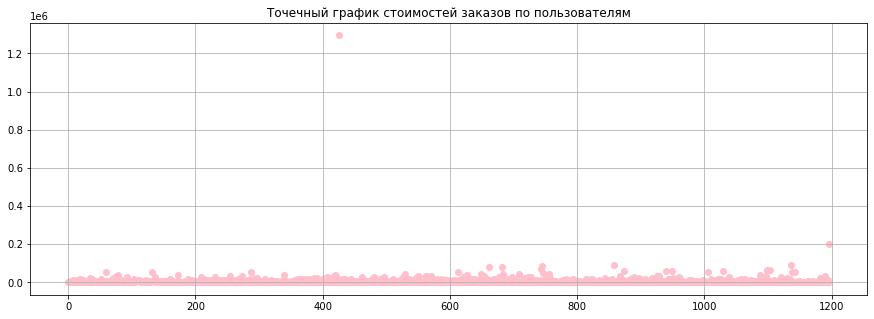

In [35]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.scatter(x_values, orders['revenue'], color='pink')
plt.grid()
plt.title('Точечный график стоимостей заказов по пользователям');

Видим, 2 очень больших выброса, которые отмечали ранее. Они не позволяют рассмотреть другие значения. Посмотрим немного поближе, изменив границы графика.

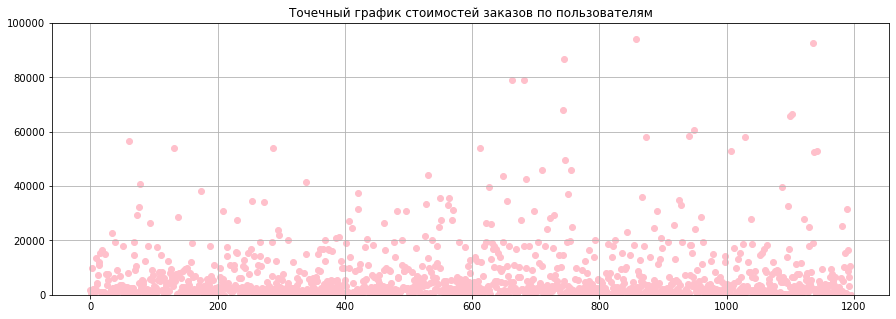

In [36]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.scatter(x_values, orders['revenue'], color='pink')
plt.grid()
plt.title('Точечный график стоимостей заказов по пользователям')
plt.ylim(0,100000);

Видим наибольшее скопление значении до 40 000. Решение о границе выбросов примем после расчета 95 и 99 процентилей

#### Расчет 95-го и 99-го перцентилей стоимости заказов

Расчитаем 95й и 99й перцентили стоимости заказов, чтобы определить границу, значения выше которой будем считать аномальными.

In [37]:
np.percentile(orders['revenue'],[95,99])

array([28000. , 58233.2])

По расчету перцентилей видим, что 5% пользователей потратили больше 28 тыс. долларов на свои заказы, а 1% пользователей - более 58 тыс. долларов.

Установим границу аномальных стоимостей заказов равную 40 тысячам.

### Расчет статистической значимости

#### Cтатистическая значимость различий в конверсии между группами по «сырым» данным

Подготовим данные для расчета. Для каждой группы создадим переменные `sample_a` и `sample_b`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [38]:
orders_by_users_a = orders.query('group == "A"').groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})
orders_by_users_b = orders.query('group == "B"').groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})
orders_by_users_a.columns = ['user_id', 'orders']
orders_by_users_b.columns = ['user_id', 'orders']

In [39]:
visits_a = visits.query('group == "A"')['visitors'].sum()
visits_b = visits.query('group == "B"')['visitors'].sum()

In [40]:
sample_a = pd.concat([
    orders_by_users_a['orders'], 
    pd.Series(0,index=np.arange(visits_a - len(orders_by_users_a['orders'])))
],axis=0)

sample_b = pd.concat([
    orders_by_users_b['orders'], 
    pd.Series(0,index=np.arange(visits_b - len(orders_by_users_b['orders'])))
],axis=0)

Зададим нулевую и альтернативную гипотезу
- H0 : статистически значимых различий в конверсии между группами А и В нет
- H1: есть статистические различия в конверсии между группами А и В

Уровень статистической значимости установим равный 0.05

Т.к. в исходных данных имеются большие выбросы расчитаем статистическую значимость методом Манна-Уитни. Также посчитаем разницу между средними двух групп.

In [41]:
print('Разница между средними групп А и В:', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

Разница между средними групп А и В: 0.138


In [42]:
alpha = 0.05
p_value = stats.mannwhitneyu(sample_a, sample_b)[1]
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    print('p-value:', p_value)
else: (print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'),
        print('p-value:', p_value))

Отвергаем нулевую гипотезу: между долями есть значимая разница
p-value: 0.016792355056752608


Полученное значение p-value = 0,016 меньше уровня статистической значимости, соответственно вероятность получить такую же или большую разницу при верной нулевой гипотезе крайне мала. Отвергаем нулевую гипотезу. Различия между группами статистически значимы.

#### Cтатистическая значимость различий в среднем чеке между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между группами.

Зададим нулевую и альтернативную гипотезу
- H0 : статистических различий в среднем чеке между группами А и В нет
- H1: есть статистические различия в среднем чеке между группами

Уровень статистической значимости установим равный 0.05

In [43]:
print('Разница между средними групп А и В:', 
      "{0:.3f}".format(orders.query('group == "B"')['revenue'].mean() / orders.query('group == "A"')['revenue'].mean() -1))

Разница между средними групп А и В: 0.259


In [44]:
alpha = 0.05
p_value = stats.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1]
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    print('p-value:', p_value)
else: (print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'),
        print('p-value:', p_value))

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-value: 0.7292909855432458


Полученное значение p-value = 0,729 больше уровня статистической значимости, значит нулевую гипотезу мы не отвергаем и нет причин считать, что в среднем чеке двух групп есть различия. 

Таким образом разница в 25,9% между группами не является статистически значимой. Возможно, это влияние выбросов. 

Далее посмотрим расчеты по "очищенным данным", без выбросов.

#### Удаление аномальных значений

Подготовим список с пользователями, которые совершили более 3 заказов и заказы более, чем на 40 000.

In [45]:
users_with_many_orders = pd.concat([
        orders_by_users_a.query('orders > 3')['user_id'],
        orders_by_users_b.query('orders > 3')['user_id'],
    ],
    axis=0)
users_with_exp_orders = orders.query('revenue > 40000')['visitor_id']

abnormal_users = pd.concat([users_with_many_orders, users_with_exp_orders],axis=0).drop_duplicates()

abnormal_users.shape[0]

34

Всего 34 "аномальных" пользователя. Теперь подготовим выборки заказов для расчета по "очищенным данным"

In [46]:
sample_a_filtered = pd.concat([
    orders_by_users_a[np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))]['orders'], 
    pd.Series(0,index=np.arange(visits_a - len(orders_by_users_a['orders'])))
],axis=0)

sample_b_filtered = pd.concat([
    orders_by_users_b[np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))]['orders'], 
    pd.Series(0,index=np.arange(visits_b - len(orders_by_users_b['orders'])))
],axis=0)

Также сохраним в отдельные переменные выборки для расчетов по среднему чеку.

In [47]:
sample_a_filtered_bill = orders[np.logical_and(
                            orders['group'] == "A", np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']

sample_b_filtered_bill = orders[np.logical_and(
                            orders['group'] == "B", np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue']

Переходим к расчетам. Гипотезы и уровень статистической значимости те же.

#### Cтатистическая значимость различий в конверсии между группами по «очищенным» данным

Зададим нулевую и альтернативную гипотезу
- H0 : статистически значимых различий в конверсии между группами А и В по "очищенным данным" нет
- H1: есть статистические различия в конверсии между группами по "очищенным данным"

Уровень статистической значимости установим равный 0.05

In [48]:
print('Разница между средними групп А и В:', "{0:.3f}".format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

Разница между средними групп А и В: 0.164


In [49]:
alpha = 0.05
p_value = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    print('p-value:', p_value)
else: (print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'),
        print('p-value:', p_value))

Отвергаем нулевую гипотезу: между долями есть значимая разница
p-value: 0.009307722667034158


Результаты практически не изменились, P-value стал ещё меньше, а разница между средними стала больше.

Мы так же отвергаем гипотезу о равенстве конверсии в группах А и В. Имеются статистически значимые различия в конверсиях двух групп

#### Cтатистическая значимость различий в среднем чеке между группами по «очищенным» данным

Зададим нулевую и альтернативную гипотезу
- H0 : статистических различий в среднем чеке между группами А и В нет
- H1: есть статистические различия в среднем чеке между группами

In [50]:
print('Различия в среднем чеке между группами А и В:', "{0:.3f}".format(sample_b_filtered_bill.mean() / sample_a_filtered_bill.mean() - 1))

Различия в среднем чеке между группами А и В: 0.060


In [51]:
alpha = 0.05
p_value = stats.mannwhitneyu(sample_a_filtered_bill,sample_b_filtered_bill)[1]
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    print('p-value:', p_value)
else: (print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'),
        print('p-value:', p_value))

Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-value: 0.7109821423993444


Здесь результаты также практически не изменились. Т.е. мы так же не отвергаем нулевую гипотезу, как и в расчете по "сырым" данным, но теперь разница между средними значениями стала значительно меньше. 

### Выводы

По результатам теста и расчетов можем сделать следующие выводы:
1. Есть статистически значимые различия по среднему количеству заказов (конверсии) между группами как по «сырым», так и по данным после фильтрации аномалий;
2. Нет статистически значимого различия в среднем чеке между группами ни по «сырым» данным, ни по данным после фильтрации аномалий;
3. График различия конверсии между группами сообщает, что результаты группы B стабильно лучше группы A
4. График различия среднего чека говорит о том, что результаты группы B лучше группы А, разница положительная, но не очень большая. На графиках ниже , построенных по отфильтрованным данным, это видно более наглядно.

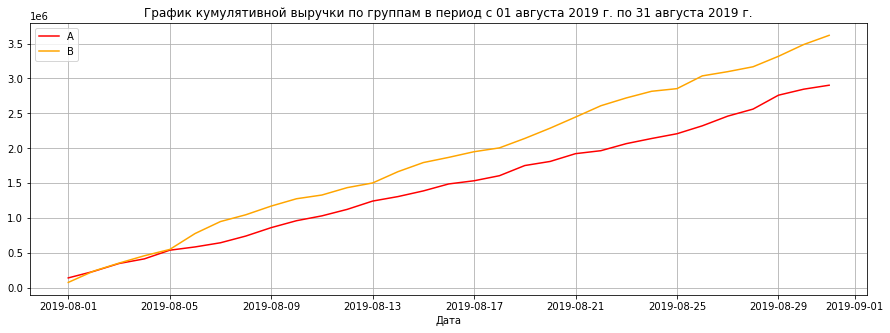

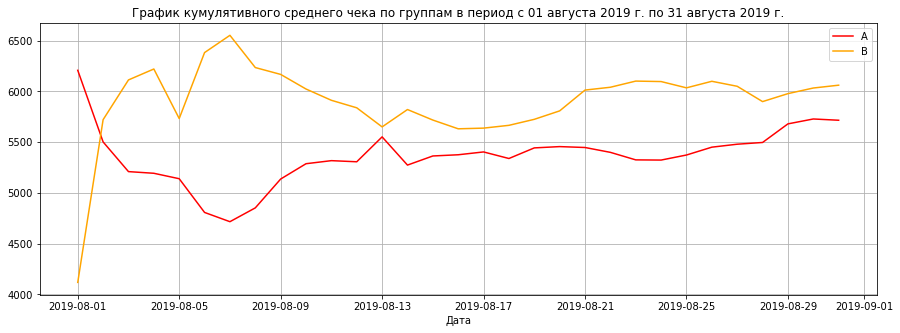

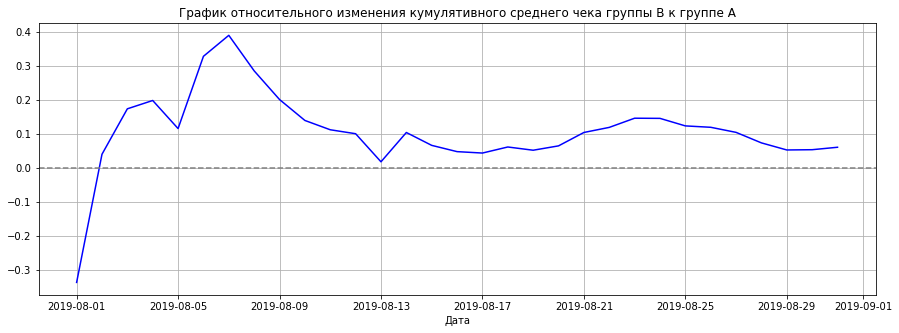

In [52]:
orders_f = orders[~orders['visitor_id'].isin(abnormal_users)]

c_data, c_revenue_a, c_revenue_b, merged_c_revenue = cumulative_dt(orders_f,visits)

revenue_plot(c_revenue_a, c_revenue_b, merged_c_revenue)

Исходя из обнаруженных фактов, считаю, что нужно закончить тест и зафиксировать победу группы В.
Все показатели вышли в плюс (хотя где-то в незначительный). При выросшей конверсии и стабильном среднем чеке общая выручка будет только расти.

